In [1]:
import os
import torch
import librosa
import librosa.display
import scipy
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import math

In [2]:
speach_path = "../../dataset/en/clips"
noise_path = "../../dataset/noise_dataset/audio/fold3"

noise_filename = '18594-1-1-0.wav'
speach_filename = 'common_voice_en_18049326.mp3'

fs = 16e3 # Hz sampling frequency
windowLength = 256
fftLength = windowLength
overlap = round(0.25 * windowLength) # overlap of 75%
window = scipy.signal.hamming(windowLength, sym=False)
numSegments = 8
numFeatures = fftLength // 2 + 1

device=torch.device("cuda")

## Utilities

In [3]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    #Normalization?
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr

def remove_silent_frames(audio, filename):
    
    array_sum = np.sum(audio)
    array_has_nan = np.isnan(array_sum)
    
    if array_has_nan:
        print("NNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNNNNNNNN", filename)
    
    trimed_audio = []
    indices = librosa.effects.split(audio, hop_length = overlap, top_db=20)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)


def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noise_segment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_segment ** 2)
    noisy_audio = clean_audio + np.sqrt(speech_power / noise_power / 4) * noise_segment
    return noisy_audio



def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

## Model

In [4]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)
    
class PrintShape(nn.Module):
    def __init__(self,i):
        super().__init__()
        self.i=i
    def forward(self, x):
        print("PrintShape: stage:",self.i,"shape",x.shape)
        return x
    
class SaveConnection(nn.Module):
    def __init__(self,i):
        super().__init__()
        #print("lista sad init:",saved_connections)
        self.i=i
        #if i==0:
        #    saved_connections=[]
        if self.i==len(saved_connections):
            saved_connections.append(-1)
        else:
            print("dodaje se konekcija na lose mesto: i,len:",i,len(saved_connections))
    def forward(self, x):
        saved_connections[self.i]=x
        return x

class AddConnection(nn.Module):
    def __init__(self,index):
        super().__init__()
        self.index=index
    def forward(self,x):
        return saved_connections[self.index]+x    
    
saved_connections=[]

model = nn.Sequential(
    Lambda(lambda x: x.view(-1, 1, numFeatures, 8)),
    #PrintShape(0),

    nn.Conv2d(1, 18, kernel_size=(9,8), padding = (4,0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),
    #PrintShape(10),

    nn.Conv2d(18, 30, kernel_size=(5,1), padding = (2, 0), bias = False),
    SaveConnection(0),
    nn.ReLU(),
    nn.BatchNorm2d(30),
    #PrintShape(11),

    nn.Conv2d(30, 8, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(1),
    # -- 1

    nn.Conv2d(8, 18, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(5,1), padding = (2, 0), bias = False),
    SaveConnection(1),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(2),
    # -- 2   
    
    nn.Conv2d(8, 18, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(5,1), padding = (2, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(3),
    # -- 3

    nn.Conv2d(8, 18, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(5,1), padding = (2, 0), bias = False),
    AddConnection(1),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(4),
    # -- 4 

    nn.Conv2d(8, 18, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(18),

    nn.Conv2d(18, 30, kernel_size=(5,1), padding = (2, 0), bias = False),
    AddConnection(0),
    nn.ReLU(),
    nn.BatchNorm2d(30),

    nn.Conv2d(30, 8, kernel_size=(9,1), padding = (4, 0), bias = False),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    #PrintShape(5),
    # -- 5
    
    nn.Dropout(p=0.2),
    nn.Conv2d(8, 1, kernel_size=(129,1), padding = (64,0))

)


model


Sequential(
  (0): Lambda()
  (1): Conv2d(1, 18, kernel_size=(9, 8), stride=(1, 1), padding=(4, 0), bias=False)
  (2): ReLU()
  (3): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(18, 30, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
  (5): SaveConnection()
  (6): ReLU()
  (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(30, 8, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (9): ReLU()
  (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(8, 18, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (12): ReLU()
  (13): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(18, 30, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
  (15): SaveConnection()
  (16): ReLU()
  (17): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [5]:
PATH = "../../model/trenutniModel.pth"

model.load_state_dict(torch.load(PATH))

model.cuda()

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "3.running_mean", "3.running_var", "4.weight", "7.running_mean", "7.running_var", "8.weight", "10.weight", "10.bias", "10.running_mean", "10.running_var", "11.weight", "13.weight", "13.bias", "13.running_mean", "13.running_var", "14.weight", "17.weight", "17.bias", "17.running_mean", "17.running_var", "18.weight", "20.weight", "20.bias", "20.running_mean", "20.running_var", "21.weight", "23.weight", "23.bias", "23.running_mean", "23.running_var", "24.weight", "26.weight", "26.bias", "26.running_mean", "26.running_var", "27.weight", "29.weight", "29.bias", "29.running_mean", "29.running_var", "30.weight", "32.weight", "32.bias", "32.running_mean", "32.running_var", "33.weight", "36.weight", "36.bias", "36.running_mean", "36.running_var", "37.weight", "39.weight", "39.bias", "39.running_mean", "39.running_var", "40.weight", "42.weight", "42.bias", "42.running_mean", "42.running_var", "43.weight", "46.weight", "46.bias", "46.running_mean", "46.running_var", "47.weight", "49.weight", "49.bias", "49.running_mean", "49.running_var", "51.weight", "51.bias". 
	Unexpected key(s) in state_dict: "1.bias", "5.weight", "5.bias". 
	size mismatch for 1.weight: copying a param with shape torch.Size([1024, 129]) from checkpoint, the shape in current model is torch.Size([18, 1, 9, 8]).
	size mismatch for 3.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 3.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([18]).
	size mismatch for 7.weight: copying a param with shape torch.Size([129, 1024]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for 7.bias: copying a param with shape torch.Size([129]) from checkpoint, the shape in current model is torch.Size([30]).

In [ ]:
clean_audio, sampl_rate_clean = read_audio(os.path.join(speach_path, speach_filename), sample_rate=fs)

noise_audio, sampl_rate_noise = read_audio(os.path.join(noise_path, noise_filename), sample_rate=fs)

print(sampl_rate_clean)

clean_audio = remove_silent_frames(clean_audio, "")
noise_audio = remove_silent_frames(noise_audio, "")

#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

#ax1.plot(clean_audio)
#ax1.set_title("Clean Audio")

#ax2.plot(noise_audio)
#ax2.set_title("Noise Audio")

#print("Min:", np.min(clean_audio),"Max:",np.max(clean_audio))


## Clean

In [ ]:
clean_audio_stft = librosa.stft(clean_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
clean_audio_stft_abs = np.abs(clean_audio_stft)
clean_audio_stft_abs_db = librosa.amplitude_to_db(clean_audio_stft_abs,ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(clean_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Clean sound')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=clean_audio, rate=sampl_rate_clean) # load a local WAV file

## Noise

In [ ]:
noise_audio_stft = librosa.stft(noise_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
noise_audio_stft_abs = np.abs(noise_audio_stft)
noise_audio_stft_abs_db = librosa.amplitude_to_db(noise_audio_stft_abs,ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(noise_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Noise')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=noise_audio, rate=sampl_rate_noise) # load a local WAV file

## Noised audio

In [ ]:
noise_and_audio = add_noise_to_clean_audio(clean_audio, noise_audio)

noise_and_audio_stft = librosa.stft(noise_and_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
noise_and_audio_stft_abs = np.abs(noise_and_audio_stft)
noise_and_audio_stft_phase = np.angle(noise_and_audio_stft)


noise_and_audio_stft_abs_db = librosa.amplitude_to_db(noise_and_audio_stft_abs, ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(noise_and_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Noisy speach')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


#noisy_mean = np.mean(noise_and_audio_stft_abs)
#noisy_std = np.std(noise_and_audio_stft_abs)
#noise_and_audio_stft_abs = (noise_and_audio_stft_abs - noisy_mean) / noisy_std

ipd.Audio(data=noise_and_audio, rate=sampl_rate_clean) 


## Chunk formation (129x8)

In [6]:
noise_and_speach_chunks = prepare_input_features(noise_and_audio_stft_abs, numSegments, numFeatures)
noise_and_speach_chunks = np.transpose(noise_and_speach_chunks, (2, 0, 1))
#print(noise_and_speach_chunks.shape)

noise_and_speach_chunks = noise_and_speach_chunks.astype(np.float32)
noise_and_speach_chunks = torch.from_numpy(noise_and_speach_chunks)

#print(noise_and_speach_chunks)

NameError: name 'noise_and_audio_stft_abs' is not defined

## Provlacenje kroz model

In [23]:
spectrogram_stft = [] 

#print(len(noise_and_speach_chunks))

for inp in noise_and_speach_chunks:
    x = inp.cuda()
    y = model(x).cpu()
    #print(y[0,0].detach().numpy().shape)
    
    spectrogram_stft.append(y[0,0].detach().numpy())
    
spectrogram_stft = np.array(spectrogram_stft)
spectrogram_stft = np.squeeze(spectrogram_stft)
spectrogram_stft = np.transpose(spectrogram_stft, (1, 0))

#print(spectrogram_stft.shape)

## Revert

In [24]:
def revert_stft_to_audio(stft_spectrogram, phase=None, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    
    if cleanMean is not None and cleanStd is not None:
        print("Mean/Std")
        stft_spectrogram = cleanStd * stft_spectrogram + cleanMean
    
    if phase is not None:
        print("Phase")
        stft_spectrogram = stft_spectrogram * np.exp(1j * phase)  # that fixes the abs() ope previously done

    #features = np.transpose(features, (1, 0))
    print(stft_spectrogram.shape)
    return librosa.istft(stft_spectrogram, win_length=windowLength, hop_length=overlap, window=window, center=True)

(129, 602)
Phase
(129, 602)


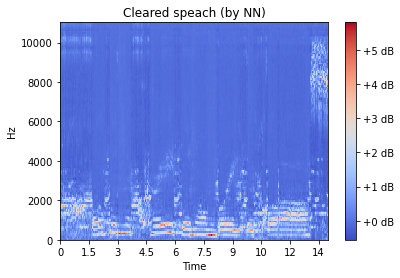

In [25]:
spectrogram_stft_db = librosa.amplitude_to_db(spectrogram_stft,ref=np.max)
print(spectrogram_stft_db.shape)
fig, ax = plt.subplots()
img = librosa.display.specshow(spectrogram_stft, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Cleared speach (by NN)')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


denoised_audio = revert_stft_to_audio(spectrogram_stft, noise_and_audio_stft_phase, None, None)


play(denoised_audio, fs)


In [26]:
print("Before loss:",((noise_and_audio_stft_abs-clean_audio_stft_abs)**2).mean())
print("After loss:",((spectrogram_stft-clean_audio_stft_abs)**2).mean())

Before loss: 0.092947066
After loss: 0.2130921
